# Load Data into frames

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import stringdist
from tqdm import tqdm
from shutil import copyfile
import gc
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from xgboost import plot_importance
import numpy as np
from keras.layers import Dense, Input, Embedding, Flatten, concatenate, Dropout, BatchNormalization, LeakyReLU, ReLU

from math import sqrt
from keras.models import Model
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping
from itertools import product
from pickle import Pickler, Unpickler
from keras import backend as K
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import keras
import sklearn
import xgboost

Using TensorFlow backend.


In [27]:
print("Pandas v:", pd.__version__)
print("Numpy v:" ,np.__version__)
print("Keras v:" ,keras.__version__)
print("Scikit-learn v:" ,sklearn.__version__)
print("XGBoost v:" ,xgboost.__version__)

Pandas v: 0.23.4
Numpy v: 1.15.2
Keras v: 2.2.3
Scikit-learn v: 0.20.0
XGBoost v: 0.82


In [28]:
FOLDER_PREFIX = "./data"

sales_train = pd.read_csv(f"{FOLDER_PREFIX}/sales_train.csv")
shops = pd.read_csv(f"{FOLDER_PREFIX}/shops.csv")
items = pd.read_csv(f"{FOLDER_PREFIX}/items.csv")
item_categories = pd.read_csv(f"{FOLDER_PREFIX}/item_categories.csv")
sales_test = pd.read_csv(f"{FOLDER_PREFIX}/test.csv")

tmp_frame = pd.merge(sales_train, items, how = "left", on = "item_id")
tmp_frame = pd.merge(tmp_frame, item_categories, how = "left", on = "item_category_id")

## Fix Date into better format

In [3]:
def fix_date_format(input_row):
  split_data = input_row.split(".")
  return f"{split_data[2]}-{split_data[1]}-{split_data[0]}"
   

sales_train["date"] = sales_train["date"].map(lambda input_row: fix_date_format(input_row))
tmp_frame["date"] = tmp_frame["date"].map(lambda input_row: fix_date_format(input_row))

## Show head of tables

In [4]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [5]:
sales_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [6]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [7]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [8]:
item_categories.head()


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


# Visualisation of Features

In [9]:
plt.style.use('ggplot')

In [10]:
def visualize_column_values(input_frame, columns = None, max_bins = 500, log_scale_cols = []):
  if columns == None:
    columns = input_frame.columns
  column_len = len(columns)
  fig, plt_arr = plt.subplots(nrows=column_len, ncols=2, figsize=(20,column_len * 5),
                              gridspec_kw = {'width_ratios':[3, 2]})
  for arr_index in range(column_len):
    if column_len == 1:
      cur_plt = plt_arr
    else:
      cur_plt = plt_arr[arr_index]
    cur_column = columns[arr_index]
    tmp_vals = input_frame[cur_column].values
    dist_vals = np.unique(tmp_vals)
    cur_plt[0].hist(tmp_vals, bins=min(len(dist_vals), max_bins), 
                    log=(cur_column in log_scale_cols))
    cur_plt[0].set_title(cur_column)
  
    
    (min_val, max_val, median_val, mean_val) = get_value_range(input_frame, 
                                                               cur_column)
    (val_05, val_10, val_90, val_95) = get_quantiles(input_frame,
                                                    cur_column)
    cur_plt[1].axis("off")
    cur_plt[1].grid(False)
    table = cur_plt[1].table(cellText=[[min_val],[max_val],
                                       [median_val],[mean_val],
                                       [val_05], [val_10],
                                       [val_90], [val_95]
                                      ],
                  rowLabels=["min", "max", "median", "mean", "Q 5%", "Q 10%", 
                             "Q 90%", "Q 95%"],
                  colWidths = [0.3],
                  loc='center')
    table.set_fontsize(20)
    table.scale(2, 2)
    
  plt.tight_layout()
  plt.show()


def get_value_range(input_frame, column):
  tmp_hist = input_frame.agg({column:["min", "max", "median", "mean"]})[column]
  return (tmp_hist['min'], tmp_hist['max'], tmp_hist['median'], tmp_hist['mean'])
    
  
def get_quantiles(input_frame, input_column):
  tmp_quant = input_frame[input_column].quantile([.05, 0.1, 0.9, .95])
  return (tmp_quant[0.05], tmp_quant[0.1], tmp_quant[0.9], tmp_quant[0.95])

# sales_train

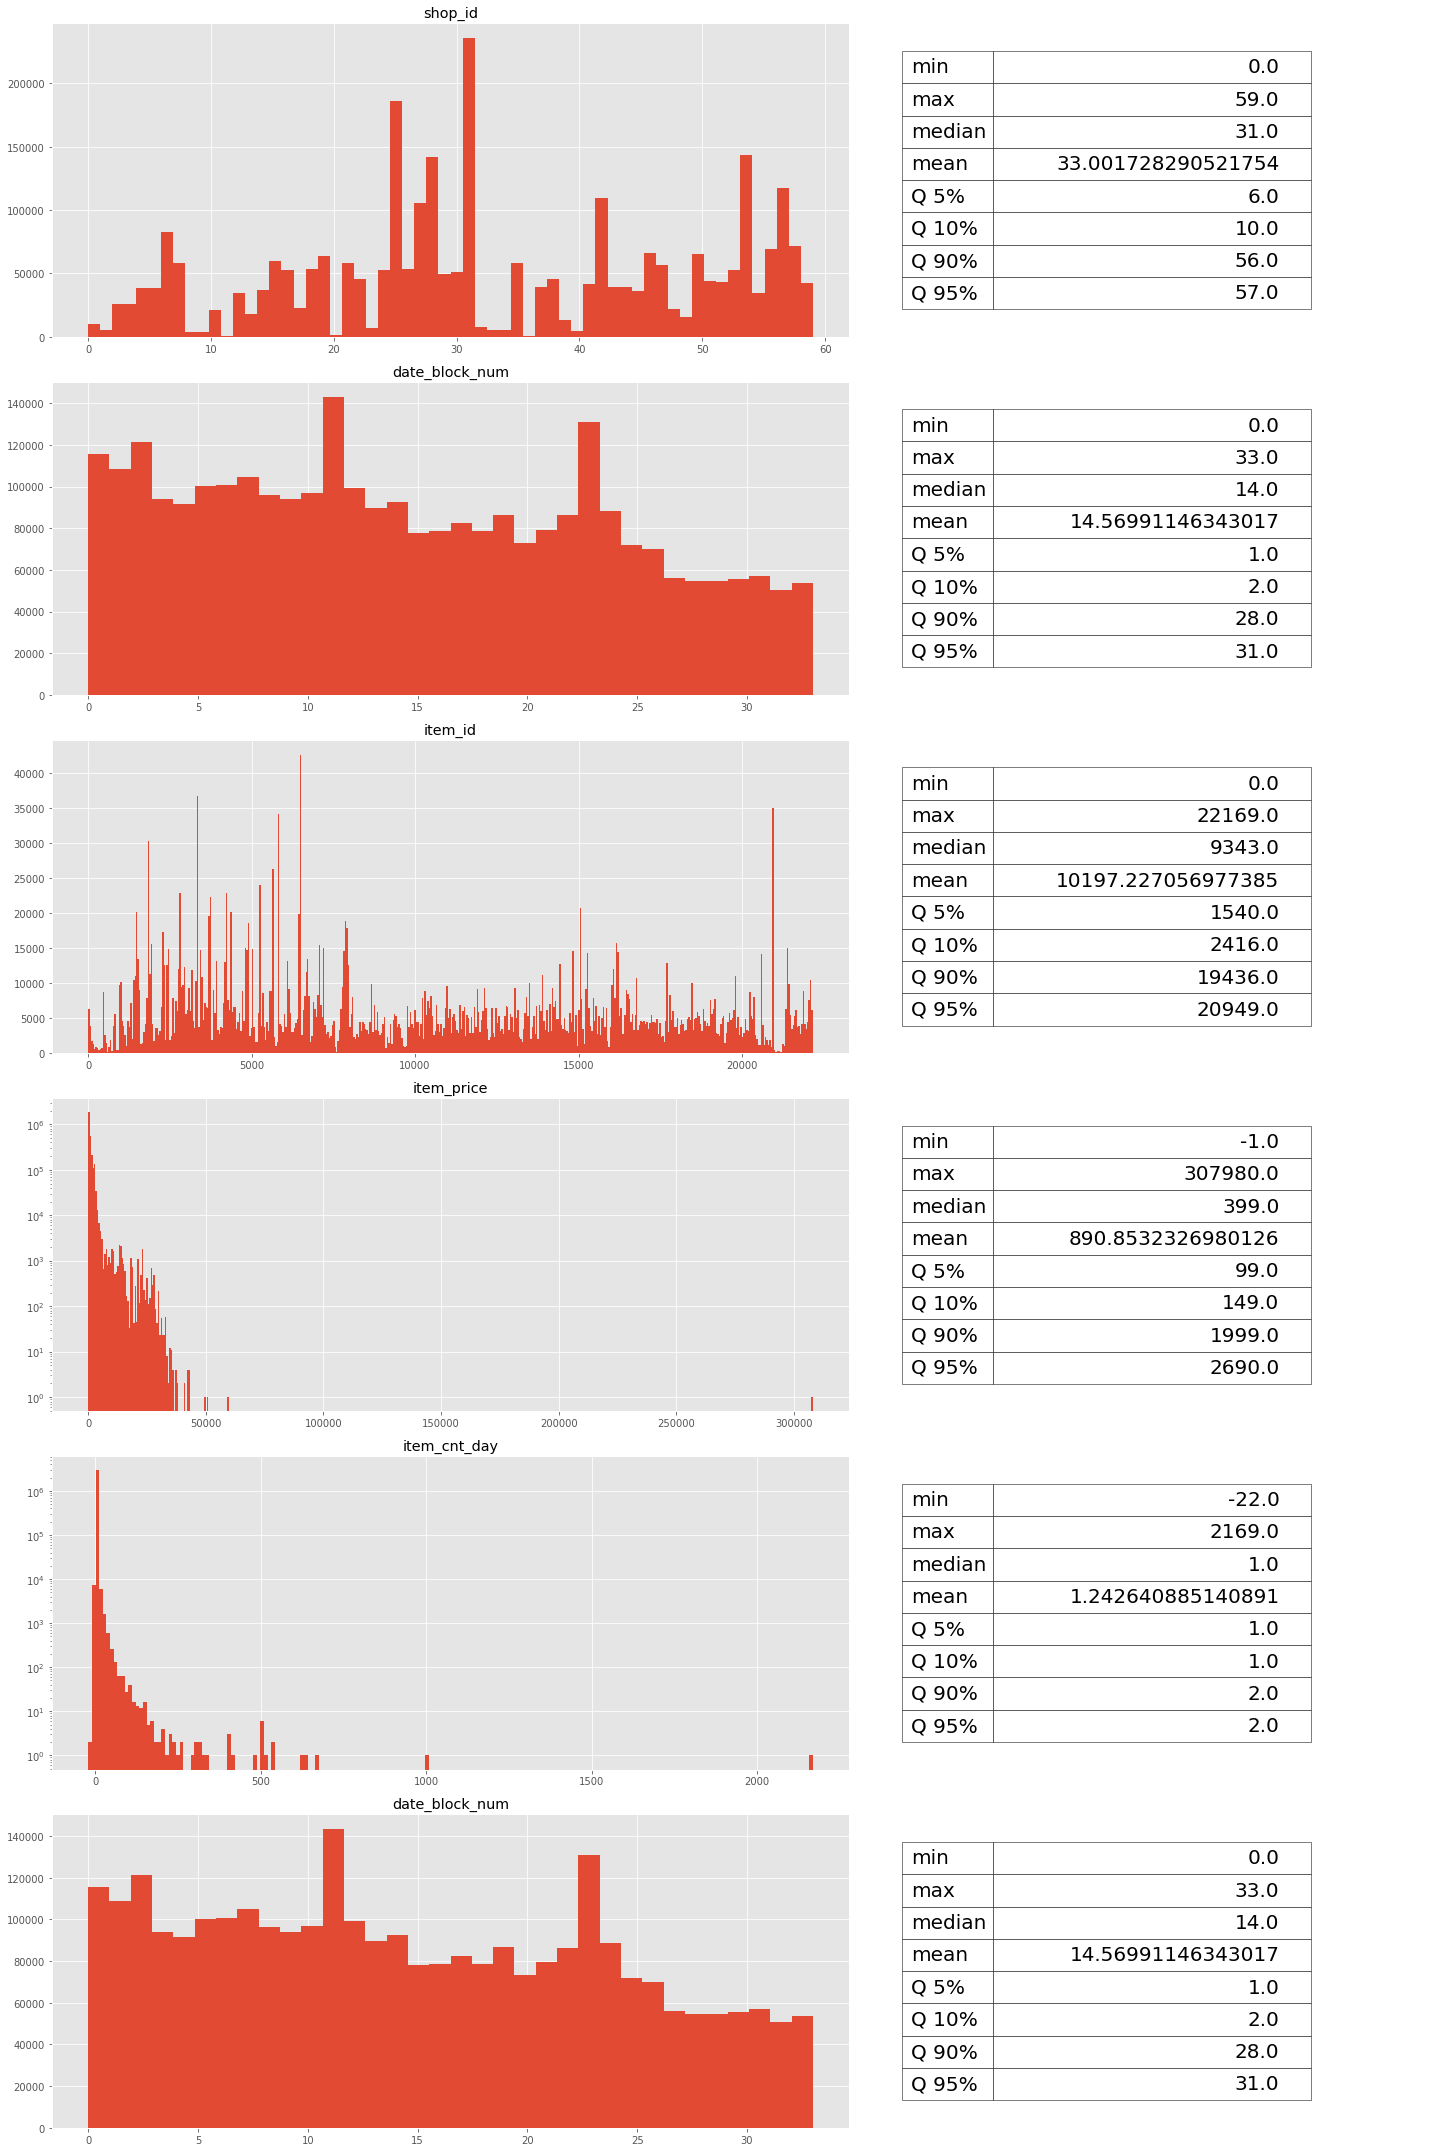

In [11]:
visualize_column_values(sales_train, columns = ["shop_id", "date_block_num", "item_id", "item_price", "item_cnt_day", "date_block_num"], log_scale_cols = ["item_price", "item_cnt_day"])

## Let's look again at item_price and item_cnt without last 10% quantile.

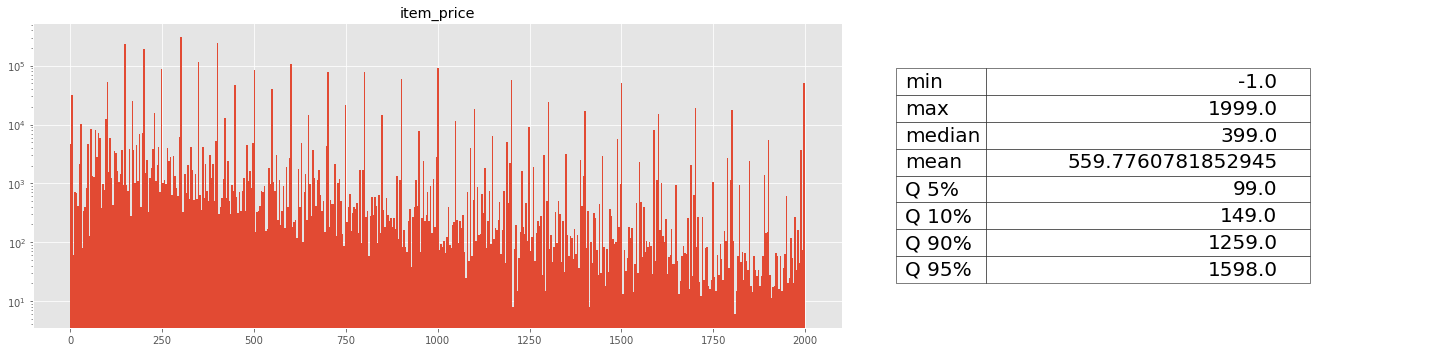

In [12]:
visualize_column_values(sales_train[sales_train["item_price"] <= 1999], columns = ["item_price"], log_scale_cols=["item_price"])

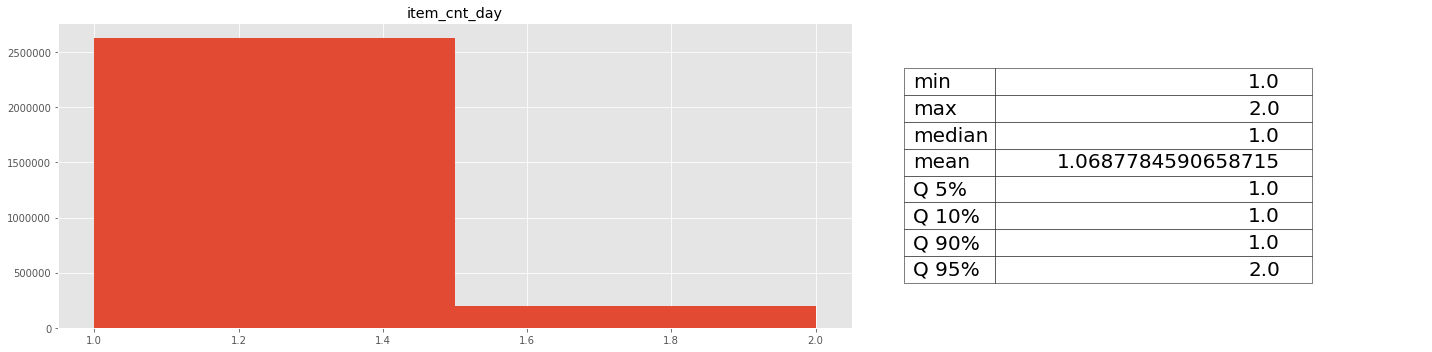

In [13]:
visualize_column_values(sales_train[(sales_train["item_cnt_day"] <= 2) & (sales_train["item_cnt_day"] > 0)], columns = ["item_cnt_day"])

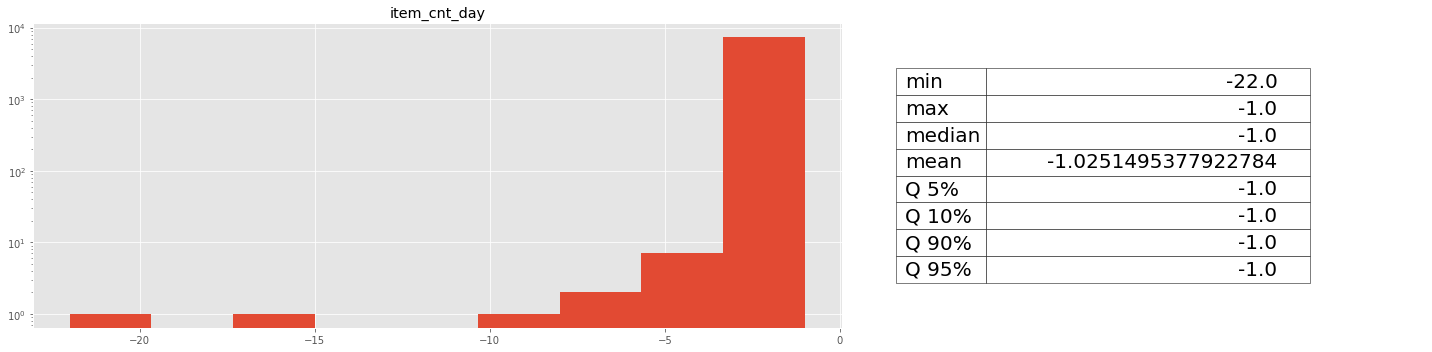

In [14]:
visualize_column_values(sales_train[sales_train["item_cnt_day"] <= 0], columns = ["item_cnt_day"], log_scale_cols=["item_cnt_day"])

# sales_test

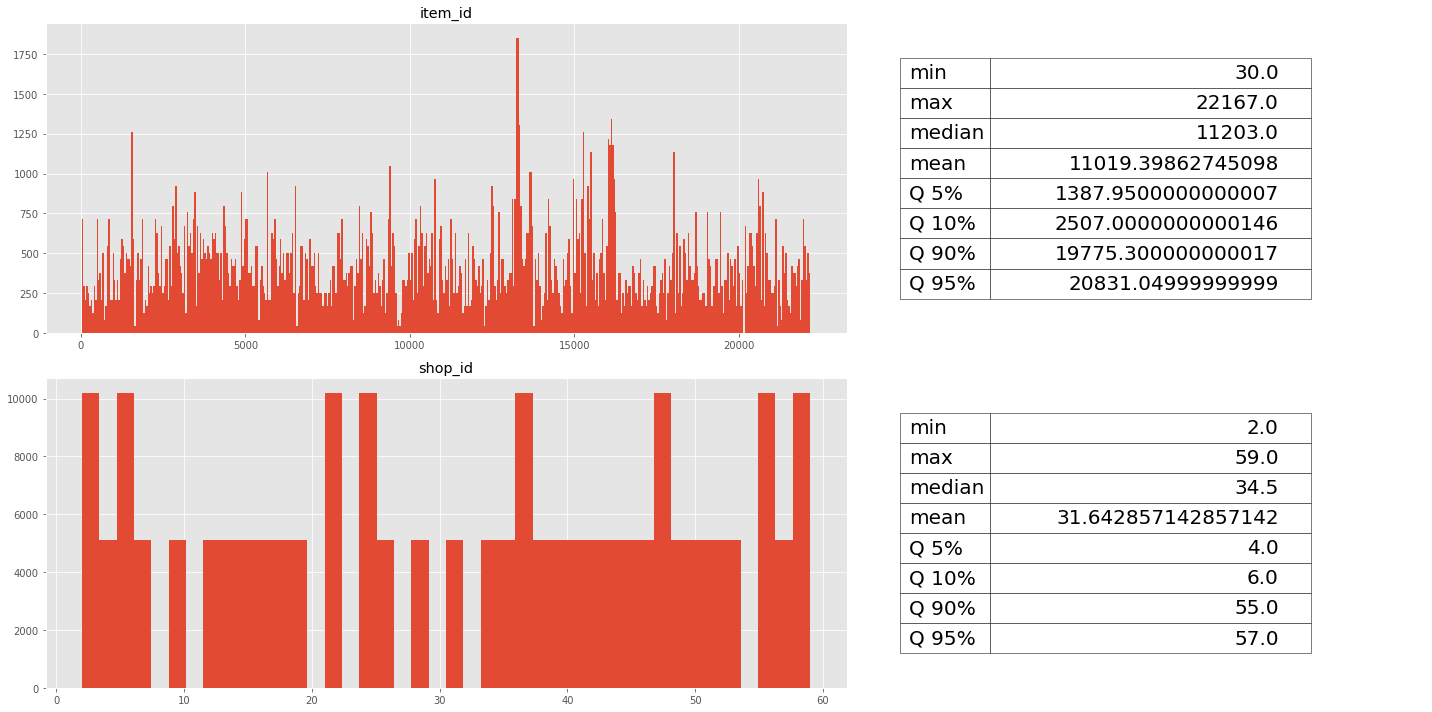

In [15]:
visualize_column_values(sales_test, ["item_id", "shop_id"])

# items

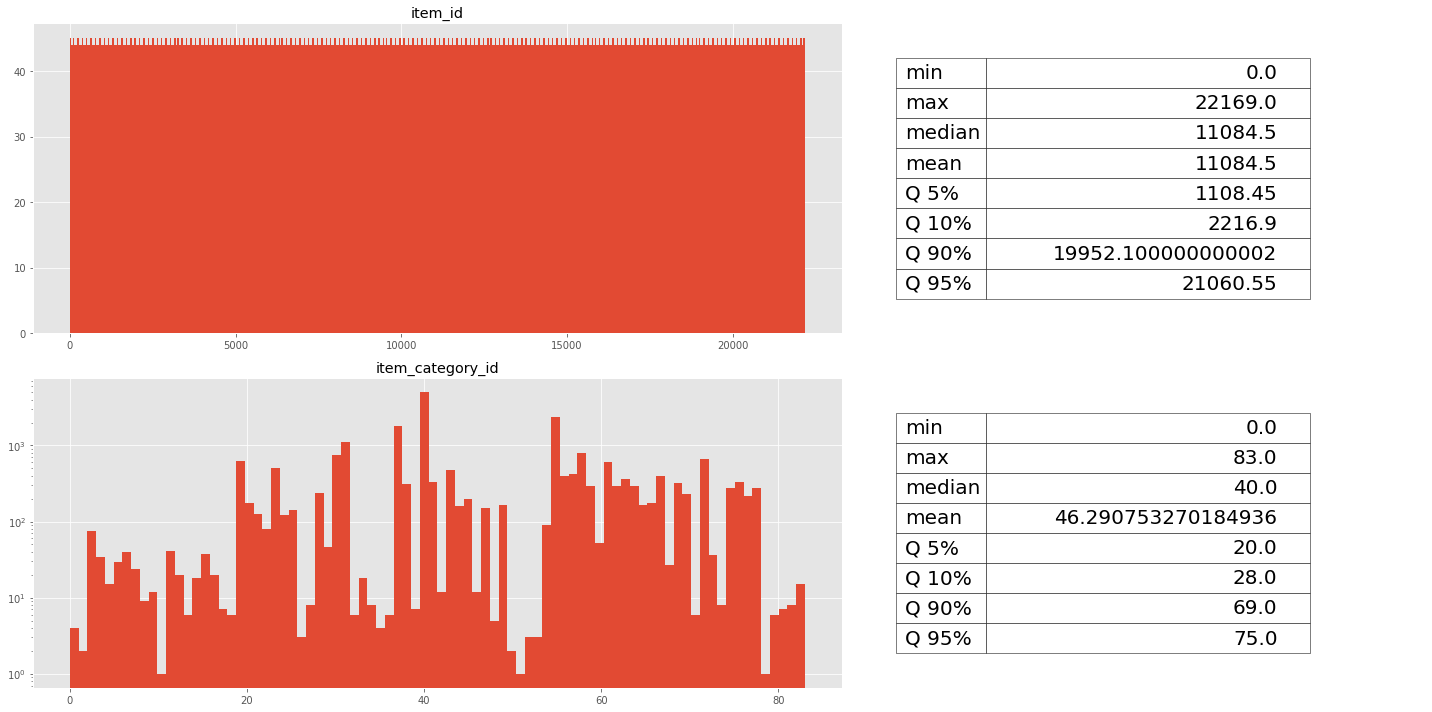

In [16]:
visualize_column_values(items, ["item_id", "item_category_id"], log_scale_cols=["item_category_id"])

# Remove outliners

In [17]:
tmp_frame[tmp_frame["item_price"] > 2690].groupby("item_category_name").agg({"item_price":["max"]}).sort_values(by = [("item_price", "max")], ascending=False).head(10)

,item_price
,max
item_category_name,
Программы - Для дома и офиса,307980.0
Доставка товара,59200.0
Подарки - Сувениры,50999.0
Игровые консоли - XBOX ONE,42990.0
Программы - 1С:Предприятие 8,35300.0
Игровые консоли - PS4,34990.0
Музыка - Винил,29999.0
Программы - Для дома и офиса (Цифра),27900.0


## Remove Radmin 3 instalation
Seems there is a wierd price high above all

In [18]:
sales_train[["item_price", "date"]].groupby("item_price").agg(["count"]).sort_values("item_price", ascending=False).head()

,date
,count
item_price,
307980.0,1
59200.0,1
50999.0,1
49782.0,1
42990.0,4


In [19]:
tmp_res = pd.merge(sales_train[sales_train["item_price"] > 300000], items, how = "left", on = "item_id")
tmp_res = pd.merge(tmp_res, item_categories, how = "left", on = "item_category_id")
tmp_res

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
0,2013-12-13,11,12,6066,307980.0,1.0,Radmin 3 - 522 лиц.,75,Программы - Для дома и офиса


In [20]:
sales_test[sales_test["item_id"] == 6066]

,ID,shop_id,item_id


In [21]:
sales_train[sales_train["item_id"] == 6066]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,2013-12-13,11,12,6066,307980.0,1.0


Item category: Programs - Home and Office

Item name: Radmin 3 - 522 persons. 

Seems like instalation of remote connection to PC to 522 persons ==> can be removed

In [22]:
sales_train = sales_train[sales_train["item_id"] != 6066]

## Negative or zero price?

In [23]:
sales_train[["item_price", "date"]].groupby("item_price").agg(["count"]).sort_values("item_price", ascending=True).head()

,date
,count
item_price,
-1.0000,1
0.0700,2
0.0875,1
0.0900,1
0.1000,2932


In [24]:
tmp_frame[tmp_frame["item_price"] == -1]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
484683,2013-05-15,4,32,2973,-1.0,1.0,"DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3


c:\users\lukas\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


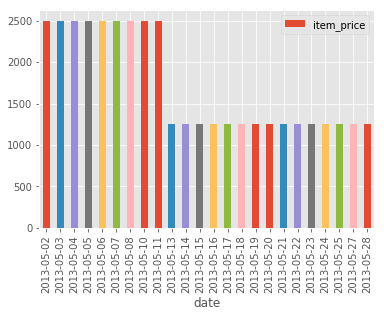

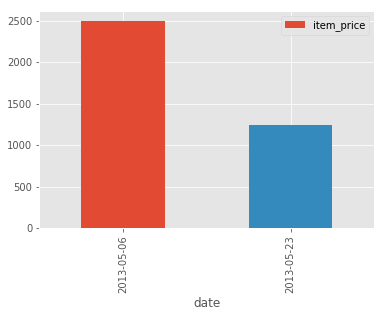

In [25]:
bought_in_month = tmp_frame[(tmp_frame["item_id"] == 2973) & (tmp_frame["item_price"] > 0) & (tmp_frame["date"] > "2013-05-01") & (tmp_frame["date"] < "2013-05-30")]
bought_in_month.groupby("date").mean().reset_index()[["date", "item_price"]].plot.bar(x="date", y="item_price")
bought_in_month[tmp_frame["shop_id"] == 32].groupby("date").mean().reset_index()[["date", "item_price"]].plot.bar(x="date", y="item_price")
plt.show()

Ok, it seems that the price was lowered in the middle of month and this shop has some problem during repricing

In [26]:
item_mean_price = bought_in_month[bought_in_month["date"] == "2013-05-15"]["item_price"].mean()

sales_train.loc[(sales_train["item_price"] == -1) & (sales_train["item_id"] == 2973), "item_price"] = item_mean_price

## Item Id peak

In [27]:
sales_train.groupby("item_id").agg({"item_id":["count"]}).sort_values(by=[("item_id", "count")], ascending=False).head()

,item_id
,count
item_id,
20949,31340
5822,9408
17717,9067
2808,7479
4181,6853


In [28]:
tmp_frame[tmp_frame["item_id"] == 20949][["item_name", "item_category_name"]].drop_duplicates()

,item_name,item_category_name
352379,Фирменный пакет майка 1С Интерес белый (34*42)...,"Подарки - Сумки, Альбомы, Коврики д/мыши"


In [29]:
tmp_frame[tmp_frame["item_category_id"] == 71]["item_name"].drop_duplicates()

26685             Крафт пакет "Интересные подарки"-оранжевый
178618                   Чехол URBAN TOOL slyDog national TR
178619                   Чехол URBAN TOOL slyDog national RU
352379     Фирменный пакет майка 1С Интерес белый (34*42)...
565293     Tucano. Коврик для мыши "Ромашка", Delikatesse...
2542075                     Крафт пакет "Интересные подарки"
Name: item_name, dtype: object

Ok .. it seems like some kind of bag of gift package or T-shirts that should be as a gift ==> may be possible:

Подарки - Сумки, Альбомы, Коврики д/мыши == Gifts - Bags, Albums, Mouse pads

Фирменный пакет майка 1С Интерес белый (34*42) == Corporate package undershirt 1C Interest white (34 * 42)


## Shop names unique check

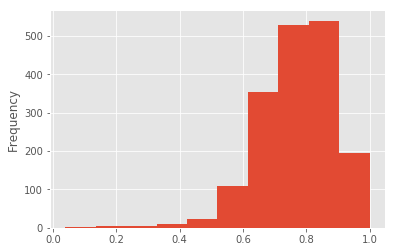

In [30]:
shops_l = shops.copy()
shops_2 = shops.copy()
shops_l["tmp"] = 1
shops_2["tmp"] = 1

dupl_shops = pd.merge(shops_l, shops_2, on = "tmp")
dupl_shops.drop("tmp", axis = 1, inplace = True)
dupl_shops = dupl_shops[dupl_shops["shop_id_x"] > dupl_shops["shop_id_y"]]
dupl_shops["distance"] = dupl_shops.apply(lambda row: stringdist.levenshtein_norm(row["shop_name_x"], row["shop_name_y"]) , axis = 1)
dupl_shops["distance"].plot.hist()

Some names appear to be pretty close one to each other. Let's check it.

In [31]:
dupl_shops[dupl_shops["distance"] < 0.3].sort_values("distance")

,shop_name_x,shop_id_x,shop_name_y,shop_id_y,distance
670,Жуковский ул. Чкалова 39м²,11,Жуковский ул. Чкалова 39м?,10,0.038462
1463,"Москва ТК ""Буденовский"" (пав.К7)",24,"Москва ТК ""Буденовский"" (пав.А2)",23,0.062500
1890,"Москва ТЦ ""Семеновский""",31,"Москва ТЦ ""Перловский""",30,0.173913
3420,"Якутск Орджоникидзе, 56",57,"!Якутск Орджоникидзе, 56 фран",0,0.206897
3481,"Якутск ТЦ ""Центральный""",58,"!Якутск ТЦ ""Центральный"" фран",1,0.206897
2439,"РостовНаДону ТРК ""Мегацентр Горизонт"" Островной",40,"РостовНаДону ТРК ""Мегацентр Горизонт""",39,0.212766
3278,"Химки ТЦ ""Мега""",54,"Омск ТЦ ""Мега""",38,0.266667
1707,"Москва ТЦ ""МЕГА Теплый Стан"" II",28,"Москва ТЦ ""МЕГА Белая Дача II""",27,0.290323


*   Жуковский ул. Чкалова 39м²	 and Жуковский ул. Чкалова 39м? looks like typo error ==> **same shop**
* Москва ТК "Буденовский" (пав.К7)	and Москва ТК "Буденовский" (пав.A2) ==> not same shop, defferent pavilons in the shopping mall
*  Москва ТЦ "Семеновский"	 and Москва ТЦ "Перловский"	 ==> not the same shop, two shopping malls
* !Якутск Орджоникидзе, 56 фран	 and Якутск Орджоникидзе, 56
 ==> **seems like a same name**
* !Якутск ТЦ "Центральный" фран	 and Якутск ТЦ "Центральный"	 ==> **seems like a same name**
* РостовНаДону ТРК "Мегацентр Горизонт" Островной	 and РостовНаДону ТРК "Мегацентр Горизонт"	==> **seems like a same name**
* Химки ТЦ "Мега"	 and Омск ТЦ "Мега"	 are in different cities ==> not same shop
* Москва ТЦ "МЕГА Теплый Стан" II	 and Москва ТЦ "МЕГА Белая Дача II"	are in same City, but different same of the mall ==> not same shop



In [32]:
same_ids = [(11, 10), (57, 0), (58, 1), (40, 39)]

def print_shop_pairs():
  for first_id, second_id in same_ids:
    first_len = len(sales_train[sales_train["shop_id"] == first_id])
    second_len = len(sales_train[sales_train["shop_id"] == second_id])
    print(f"Train id pair {first_id}/{second_id}: {first_len}/{second_len}")

    first_len = len(sales_test[sales_test["shop_id"] == first_id])
    second_len = len(sales_test[sales_test["shop_id"] == second_id])
    print(f"Test id pair {first_id}/{second_id}: {first_len}/{second_len}")
    
print_shop_pairs()

Train id pair 11/10: 499/21397
Test id pair 11/10: 0/5100
Train id pair 57/0: 117428/9857
Test id pair 57/0: 5100/0
Train id pair 58/1: 71441/5678
Test id pair 58/1: 5100/0
Train id pair 40/39: 4257/13440
Test id pair 40/39: 0/5100


In [33]:
for first_id, second_id in same_ids:
    sales_train.loc[sales_train["shop_id"] == first_id, "shop_id"] = second_id
    sales_test.loc[sales_test["shop_id"] == first_id, "shop_id"] = second_id
    
print_shop_pairs()

Train id pair 11/10: 0/21896
Test id pair 11/10: 0/5100
Train id pair 57/0: 0/127285
Test id pair 57/0: 0/5100
Train id pair 58/1: 0/77119
Test id pair 58/1: 0/5100
Train id pair 40/39: 0/17697
Test id pair 40/39: 0/5100


## Shops

* First name of the shop is name of the city.

In [34]:
def refactorize(series):
    labels, index = pd.factorize(series)
    index_len = len(index)
    target_type = np.uint8
    if index_len >= 255:
        target_type = np.uint16
    if index_len > 65535:
        target_type = np.int32
    return labels.astype(target_type)

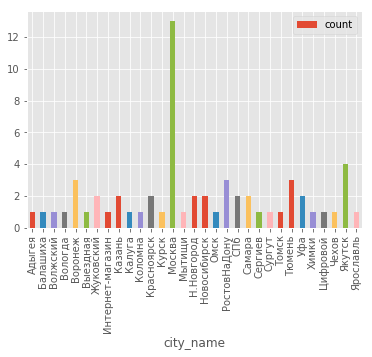

In [35]:
shops["shop_name"] = shops["shop_name"].str.replace("!", "")
shops["city_name"] = shops.apply(lambda row: row["shop_name"].split(" ")[0], axis = 1)
number_of_shops = len(shops)
shops.groupby("city_name").aggregate({"city_name": ["count"]})["city_name"].reset_index().plot.bar(x = "city_name", y = "count")
shops["city_name"] = refactorize(shops["city_name"])
shops.drop(["shop_name"], axis = 1, inplace=True)

In [36]:
shops.head()

,shop_id,city_name
0,0,0
1,1,0
2,2,1
3,3,2
4,4,3


## Categories names uniqueness

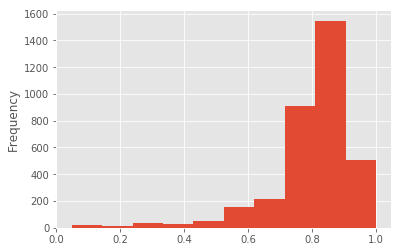

In [37]:
categ_l = item_categories.copy()
categ_2 = item_categories.copy()
categ_l["tmp"] = 1
categ_2["tmp"] = 1

dupl_categ = pd.merge(categ_2, categ_2, on = "tmp")
dupl_categ.drop("tmp", axis = 1, inplace = True)
dupl_categ = dupl_categ[dupl_categ["item_category_name_x"] > dupl_categ["item_category_name_y"]]
dupl_categ["distance"] = dupl_categ.apply(lambda row: stringdist.levenshtein_norm(row["item_category_name_x"], row["item_category_name_y"]) , axis = 1)
dupl_categ["distance"].plot.hist()

In [38]:
dupl_categ[dupl_categ["distance"] < 0.3].sort_values("distance")

,item_category_name_x,item_category_id_x,item_category_name_y,item_category_id_y,distance
1104,Игровые консоли - PSP,13,Игровые консоли - PS4,12,0.047619
1103,Игровые консоли - PSP,13,Игровые консоли - PS3,11,0.047619
1102,Игровые консоли - PSP,13,Игровые консоли - PS2,10,0.047619
1019,Игровые консоли - PS4,12,Игровые консоли - PS3,11,0.047619
934,Игровые консоли - PS3,11,Игровые консоли - PS2,10,0.047619
1018,Игровые консоли - PS4,12,Игровые консоли - PS2,10,0.047619
169,Аксессуары - PS3,2,Аксессуары - PS2,1,0.062500
253,Аксессуары - PS4,3,Аксессуары - PS2,1,0.062500
254,Аксессуары - PS4,3,Аксессуары - PS3,2,0.062500
337,Аксессуары - PSP,4,Аксессуары - PS2,1,0.062500


Seems like categories are OK, but it may be usefull to make new higher category

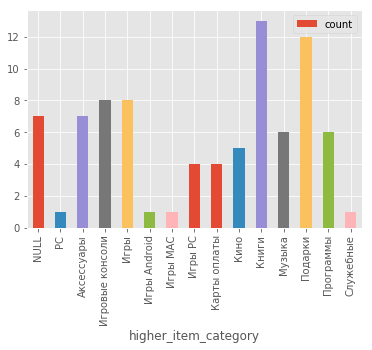

In [39]:
def split_to_higher_category(row):
  if "-" in row["item_category_name"]:
    return row["item_category_name"].split("-")[0].strip()
  else:
    return "NULL"
  
categ_l["higher_item_category"] = categ_l.apply(lambda row: split_to_higher_category(row), axis = 1)
categ_l.groupby("higher_item_category").aggregate({"higher_item_category":["count"]})["higher_item_category"].reset_index().plot.bar(x="higher_item_category", y = "count")

Fix categories for thoes, that does not have - splitter in name

In [40]:
item_categories["higher_category"] = item_categories.apply(lambda row: split_to_higher_category(row), axis = 1)
item_categories.loc[item_categories["item_category_id"] == 81, "higher_category"] = "Media"
item_categories.loc[item_categories["item_category_id"] == 82, "higher_category"] = "Media"
item_categories.loc[item_categories["higher_category"] == "NULL", "higher_category"] = item_categories.loc[item_categories["higher_category"] == "NULL"]["item_category_name"]

In [41]:
item_categories.head()

,item_category_name,item_category_id,higher_category
0,PC - Гарнитуры/Наушники,0,PC
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары


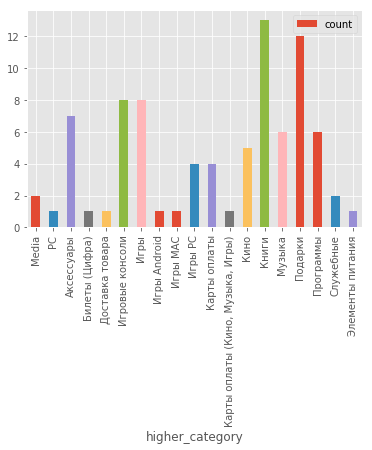

In [42]:
item_categories.groupby("higher_category").aggregate({"higher_category":["count"]})["higher_category"].reset_index().plot.bar(x="higher_category", y = "count")

In [43]:
item_categories["higher_category"] = refactorize(item_categories["higher_category"])

In [44]:
item_categories.drop("item_category_name", axis = 1, inplace = True)

In [45]:
item_categories.head()

,item_category_id,higher_category
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


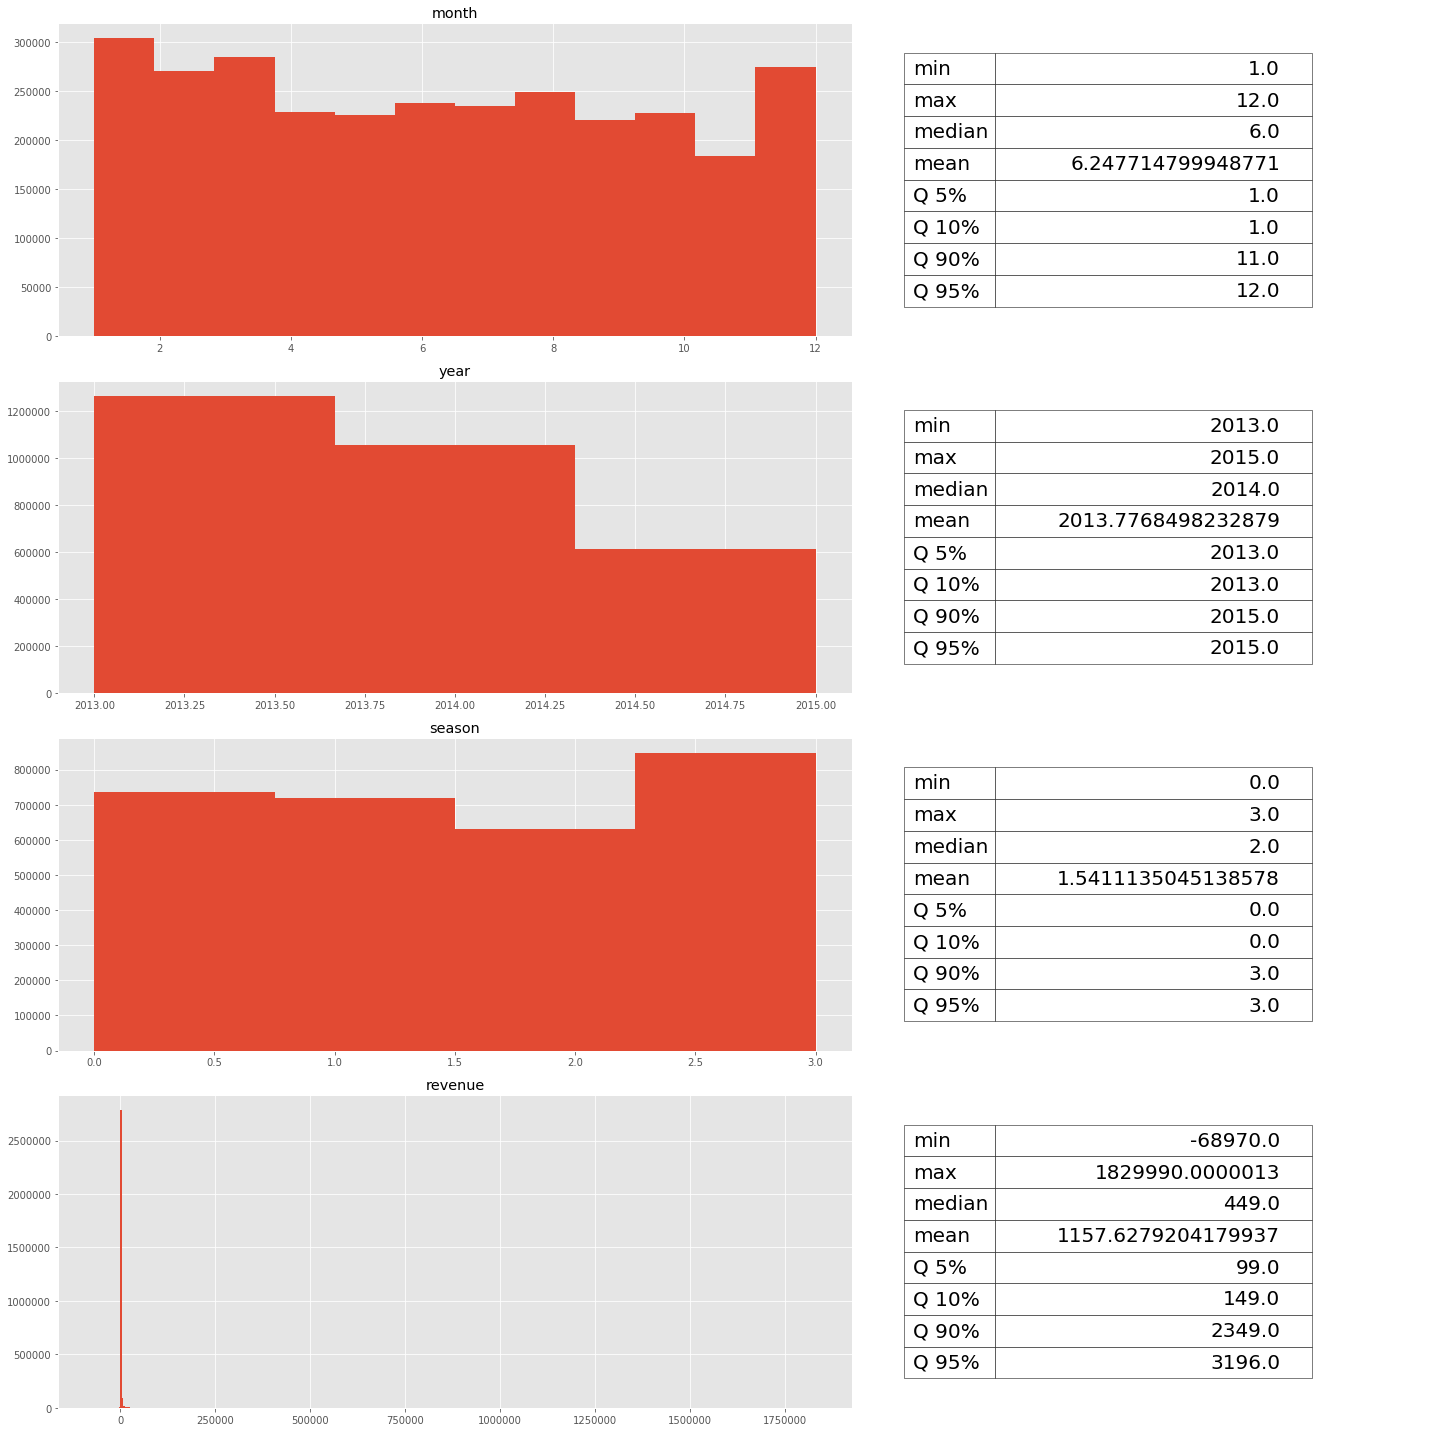

In [46]:
def day_extractor(date_part):
    return lambda input_date: int(input_date.split("-")[date_part])

# sales_train["day"] = sales_train["date"].map(day_extractor(2))
sales_train["month"] = sales_train["date"].map(day_extractor(1))
sales_train["year"] = sales_train["date"].map(day_extractor(0))
sales_train["revenue"] = sales_train["item_price"] * sales_train["item_cnt_day"]

sales_train["season"] = 3
sales_train.loc[sales_train["month"].isin([3, 4, 5]), "season"] = 0
sales_train.loc[sales_train["month"].isin([6, 7, 8]), "season"] = 1
sales_train.loc[sales_train["month"].isin([9 , 10, 11]), "season"] = 2

sales_train.drop(["date"], axis = 1, inplace = True)
visualize_column_values(sales_train, ["month", "year", "season", "revenue"])

In [47]:
date_cols = ["month", "year", "season"]
keep_cols = date_cols + ["date_block_num"]
date_block_dates = sales_train[keep_cols].drop_duplicates().reset_index()[keep_cols]

sales_train.drop(date_cols, axis = 1, inplace = True)

In [48]:
date_block_dates.loc[34] = [11, 2015, 2, 34]

In [49]:
days_in_year = {1:31,2:28,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}
working_days = {
    (2013, 1): (17, 8, 8),
    (2013, 2): (20, 8, 1),
    (2013, 3): (20, 10, 1),
    (2013, 4): (22, 8, 0),
    (2013, 5): (21, 8, 3),
    (2013, 6): (19, 10, 1),
    (2013, 7): (23, 8, 0),
    (2013, 8): (22, 9, 0),
    (2013, 9): (21, 9, 0),
    (2013, 10): (23, 8, 0),
    (2013, 11): (20, 9, 1),
    (2013, 12): (22, 9, 0),
    (2014, 1): (17, 8, 8),
    (2014, 2): (20, 8, 1),
    (2014, 3): (20, 10, 2),
    (2014, 4): (22, 8, 1),
    (2014, 5): (20, 9, 2),
    (2014, 6): (20, 9, 1),
    (2014, 7): (23, 8, 0),
    (2014, 8): (21, 10, 0),
    (2014, 9): (22, 8, 0),
    (2014, 10): (23, 8, 0),
    (2014, 11): (19, 10, 1),
    (2014, 12): (23, 8, 0),
    (2015, 1): (16, 9, 8),
    (2015, 2): (19, 8, 1),
    (2015, 3): (21, 9, 2),
    (2015, 4): (22, 8, 1),
    (2015, 5): (19, 10, 3),
    (2015, 6): (21, 8, 1),
    (2015, 7): (23, 8, 0),
    (2015, 8): (21, 10, 0),
    (2015, 9): (22, 8, 0),
    (2015, 10): (22, 9, 0),
    (2015, 11): (20, 9, 1),
    (2015, 12): (23, 8, 0),
}

def get_day_part(map_index):
    return lambda row: working_days[(row["year"], row["month"])][map_index]

date_block_dates["days_in_month"] = date_block_dates["month"].map(days_in_year)
date_block_dates["working_days"] = date_block_dates[["year", "month"]].apply(get_day_part(0), axis = 1)
date_block_dates["weekends_days"] = date_block_dates[["year", "month"]].apply(get_day_part(1), axis = 1)
date_block_dates["holidays"] = date_block_dates["days_in_month"] - date_block_dates["working_days"] - date_block_dates["weekends_days"]
date_block_dates["work_ratio"] = date_block_dates["working_days"] / (date_block_dates["weekends_days"] + date_block_dates["holidays"])

# Downscale function

In [50]:
def downcast_dtypes(df, int_type = np.int32, float_type = np.float32):
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(float_type)
    df[int_cols]   = df[int_cols].astype(int_type)
    
    return df

# Create grid of items

* Create list of pair shop/item.
* Item will start appearing in the grid when it was first sold
* Only items in the test set will be included


In [51]:
def create_item_matrix():
    res_cols = ["item_id", "shop_id", "date_block_num"]
    result_grid = []
    for date_block in tqdm(sales_train.date_block_num.drop_duplicates().values):
        date_block_items = sales_train[(sales_train.date_block_num == date_block)]["item_id"].drop_duplicates().values
        date_block_shops = sales_train[(sales_train.date_block_num == date_block)]["shop_id"].drop_duplicates().values
        result_grid.append(np.array(list(product(date_block_items, date_block_shops, [date_block])), dtype=np.int32))
    result_grid = pd.DataFrame(np.vstack(result_grid), columns = res_cols, dtype = np.int16)
    sales_test["date_block_num"] = 34
    return pd.concat((result_grid,sales_test.drop("ID", axis = 1)), sort=False).drop_duplicates().reset_index()[res_cols]

## Add additional rows into grid

* month
* year
* season
* city
* category id
* higher category id

In [52]:
%%time

grid_data = create_item_matrix()
grid_data = pd.merge(
    grid_data,
    shops,
    on = "shop_id",
    how = "left"
)

grid_data = pd.merge(
    grid_data,
    items,
    on = "item_id",
    how = "left"
).drop("item_name", axis = 1)

grid_data = pd.merge(
    grid_data,
    item_categories,
    on = "item_category_id",
    how = "left"
)

grid_data = pd.merge(
    grid_data,
    date_block_dates,
    on = "date_block_num",
    how = "left"
)

grid_data["month"] = grid_data["month"].astype(np.uint8)
grid_data["year"] = grid_data["year"].astype(np.uint16)
grid_data["season"] = grid_data["season"].astype(np.uint8)

100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:12<00:00,  3.69it/s]


Wall time: 34.4 s


# Add target value for item/shop

In [53]:
%%time

def create_target_value_feature():
    target_value = sales_train.groupby(["date_block_num", "shop_id", "item_id"]).agg({"item_cnt_day": ["sum"]}).reset_index()
    target_value.columns = ["date_block_num", "shop_id", "item_id", "item_cnt_month"]
    target_value ["item_cnt_month"] = target_value["item_cnt_month"].clip(0,20)
    return target_value

grid_data = pd.merge(
    grid_data,
    create_target_value_feature(),
    on = ["date_block_num", "shop_id", "item_id"],
    how = "left"
).fillna({"item_cnt_month": 0})

grid_data["item_cnt_month"] = grid_data["item_cnt_month"].astype(np.uint8)

Wall time: 12.9 s


## Traget item counts lags

In [54]:
def create_lag_feature(grid_frame, lags_frame, lags, col, comm_cols = None, lag_shift_col = "date_block_num"):
    if (comm_cols == None):
        comm_cols = list(np.intersect1d(grid_frame.columns, lags_frame.columns))
        print("Setting common columns into :", comm_cols)
    input_frame_shallow_copy = lags_frame[comm_cols + [col]]
    result = grid_frame
    for lag in tqdm(lags):
        shifted = input_frame_shallow_copy.copy()
        target_col = f"{col}_lag_{lag}"
        shifted.columns = comm_cols + [target_col]
        shifted[lag_shift_col] = shifted[lag_shift_col] + lag
        result = pd.merge(result, shifted, on=comm_cols, how='left')
    return result

In [55]:
%%time
grid_data = create_lag_feature(grid_data, grid_data, [1,2,3,6,12], 
                               'item_cnt_month', ["date_block_num", "shop_id", "item_id"])

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:06<00:00, 13.40s/it]


Wall time: 1min 6s


# Add history statistics data

In [56]:
def create_historical_features(group_coll, aggregate_map, cols, input_frame = sales_train):
    res_frame = input_frame.groupby(group_coll).agg(aggregate_map).reset_index()
    res_frame.columns = group_coll + cols
    return res_frame

In [57]:
%%time
hist_data = create_historical_features(["date_block_num"], 
                                       {"item_cnt_month": "mean"}, 
                                       ["global_item_mean_count"], 
                                       input_frame = grid_data)

grid_data = create_lag_feature(
    grid_data,
    hist_data,
    [1],
    "global_item_mean_count"
)

Setting common columns into : ['date_block_num']


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.90s/it]


Wall time: 12.5 s


In [58]:
%%time
hist_data = create_historical_features(["date_block_num", "shop_id"], 
                                       {"item_cnt_month": "mean"}, 
                                       ["shop_item_mean_count"], 
                                       input_frame = grid_data)

grid_data = create_lag_feature(
    grid_data,
    hist_data,
    [1,2],
    "shop_item_mean_count"
)

Setting common columns into : ['date_block_num', 'shop_id']


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:14<00:00,  8.03s/it]


Wall time: 19.6 s


In [59]:
%%time
hist_data = create_historical_features(["date_block_num", "item_id"], 
                                       {"item_cnt_month": "mean"}, 
                                       ["item_mean_count"], 
                                       input_frame = grid_data)

grid_data = create_lag_feature(
    grid_data,
    hist_data,
    [1,2],
    "item_mean_count"
)

Setting common columns into : ['date_block_num', 'item_id']


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:15<00:00,  8.71s/it]


Wall time: 21.4 s


In [60]:
%%time
hist_data = create_historical_features(["date_block_num", "item_id", "city_name"], 
                                       {"item_cnt_month": "mean"}, 
                                       ["city_item_mean_count"], 
                                       input_frame = grid_data)

grid_data = create_lag_feature(
    grid_data,
    hist_data,
    [1,2],
    "city_item_mean_count"
)

Setting common columns into : ['city_name', 'date_block_num', 'item_id']


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:23<00:00, 12.74s/it]


Wall time: 36.3 s


In [61]:
%%time
hist_data = create_historical_features(["date_block_num", "item_category_id"], 
                                       {"item_cnt_month": "mean"}, 
                                       ["category_mean_count"], 
                                       input_frame = grid_data)

grid_data = create_lag_feature(
    grid_data,
    hist_data,
    [1,2],
    "category_mean_count"
)

Setting common columns into : ['date_block_num', 'item_category_id']


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:16<00:00,  9.21s/it]


Wall time: 22.5 s


In [62]:
%%time
hist_data = create_historical_features(["date_block_num", "shop_id", "item_category_id"], 
                                       {"item_cnt_month": "mean"}, 
                                       ["shop_category_mean_count"], 
                                       input_frame = grid_data)

grid_data = create_lag_feature(
    grid_data,
    hist_data,
    [1,2],
    "shop_category_mean_count"
)

Setting common columns into : ['date_block_num', 'item_category_id', 'shop_id']


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:18<00:00, 10.10s/it]


Wall time: 25.2 s


In [63]:
%%time
hist_data = create_historical_features(["date_block_num", "higher_category"], 
                                       {"item_cnt_month": "mean"}, 
                                       ["higher_category_mean_count"], 
                                       input_frame = grid_data)

grid_data = create_lag_feature(
    grid_data,
    hist_data,
    [1,2],
    "higher_category_mean_count"
)

Setting common columns into : ['date_block_num', 'higher_category']


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:19<00:00, 10.85s/it]


Wall time: 26.6 s


In [64]:
%%time
hist_data = create_historical_features(["date_block_num", "shop_id", "higher_category"], 
                                       {"item_cnt_month": "mean"}, 
                                       ["shop_higher_category_mean_count"], 
                                       input_frame = grid_data)

grid_data = create_lag_feature(
    grid_data,
    hist_data,
    [1,2],
    "shop_higher_category_mean_count"
)

Setting common columns into : ['date_block_num', 'higher_category', 'shop_id']


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:20<00:00, 11.32s/it]


Wall time: 28.5 s


In [65]:
%%time

hist_data = create_historical_features(["year", "month", "item_id"], 
                                       {"item_cnt_month": "mean"}, 
                                       ["year_month_item_mean_count"], 
                                       input_frame = grid_data)
grid_data = create_lag_feature(
    grid_data,
    hist_data,
    [1,2],
    "year_month_item_mean_count",
    lag_shift_col = "year"
)

Setting common columns into : ['item_id', 'month', 'year']


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:21<00:00, 12.09s/it]


Wall time: 30.7 s


In [66]:
%%time

hist_data = create_historical_features(["year", "month", "shop_id"], 
                                       {"item_cnt_month": "mean"}, 
                                       ["year_month_shop_mean_count"], 
                                       input_frame = grid_data)
grid_data = create_lag_feature(
    grid_data,
    hist_data,
    [1,2],
    "year_month_shop_mean_count",
    lag_shift_col = "year"
)

Setting common columns into : ['month', 'shop_id', 'year']


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:22<00:00, 12.16s/it]


Wall time: 30.8 s


In [67]:
%%time

hist_data = create_historical_features(["year", "season", "item_id"], 
                                       {"item_cnt_month": "mean"}, 
                                       ["year_season_item_mean_count"], 
                                       input_frame = grid_data)
grid_data = create_lag_feature(
    grid_data,
    hist_data,
    [1,2],
    "year_season_item_mean_count",
    lag_shift_col = "year"
)

Setting common columns into : ['item_id', 'season', 'year']


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:23<00:00, 12.88s/it]


Wall time: 32.5 s


In [68]:
%%time

hist_data = create_historical_features(["year", "season", "shop_id"], 
                                       {"item_cnt_month": "mean"}, 
                                       ["year_season_shop_mean_count"], 
                                       input_frame = grid_data)
grid_data = create_lag_feature(
    grid_data,
    hist_data,
    [1,2],
    "year_season_shop_mean_count",
    lag_shift_col = "year"
)

Setting common columns into : ['season', 'shop_id', 'year']


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:23<00:00, 13.36s/it]


Wall time: 33.3 s


# Create mean encoding feature for categorical features

In [69]:
categorical_columns = ["item_id", "shop_id", "city_name", "item_category_id", "higher_category", "month", "year", "season"]

In [70]:
%%time

def create_mean_features(col_name):
    col_mean_res = grid_data[grid_data.date_block_num < 33].groupby(col_name).agg({"item_cnt_month": ["mean"]}).reset_index()
    col_mean_dict = {name:mean_val for name,mean_val in col_mean_res.values}
    cumsum = grid_data.groupby(col_name)["item_cnt_month"].cumsum() - grid_data["item_cnt_month"]
    cumcnt = grid_data.groupby(col_name).cumcount()
    target_enc_col = f"{col_name}_mean_enc"
    grid_data[target_enc_col] = cumsum/cumcnt
    grid_data.loc[grid_data.date_block_num >= 33, target_enc_col] = grid_data[grid_data.date_block_num >= 33][col_name].map(col_mean_dict).fillna(0)
    grid_data[target_enc_col] = grid_data[target_enc_col].astype(np.float32)
    return col_mean_dict


mean_encode_dict = {col: create_mean_features(col) for col in tqdm(categorical_columns)}

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [03:05<00:00, 22.81s/it]


Wall time: 3min 5s


# Delta features

In [71]:
grid_data = grid_data.fillna(0)

In [72]:
%%time
def create_delta_lags(column_name, delta_lags = [1]):
    for delta_lag in tqdm(delta_lags):
        grid_data[f"{column_name}_delta_{delta_lag}"] = grid_data[f"{column_name}_{delta_lag}"] - grid_data[f"{column_name}_{delta_lag + 1}"]
        

create_delta_lags("item_cnt_month_lag", delta_lags = [1,2])
create_delta_lags("shop_item_mean_count_lag")
create_delta_lags("item_mean_count_lag")
create_delta_lags("city_item_mean_count_lag")
create_delta_lags("category_mean_count_lag")
create_delta_lags("shop_category_mean_count_lag")
create_delta_lags("higher_category_mean_count_lag")
create_delta_lags("shop_higher_category_mean_count_lag")
create_delta_lags("year_month_item_mean_count_lag")
create_delta_lags("year_month_shop_mean_count_lag")
create_delta_lags("year_season_item_mean_count_lag")
create_delta_lags("year_season_shop_mean_count_lag")

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.41it/s]


Wall time: 2.16 s


# Drop items before training

In [73]:
%%time
grid_data = grid_data[grid_data.date_block_num > 11]

Wall time: 16.4 s


# Add testing ID into grid

In [74]:
grid_data = pd.merge(
    grid_data,
    sales_test,
    on=["shop_id", "item_id", "date_block_num"],
    how="left"
)

# Save and load results

In [75]:
grid_data.to_parquet("./grid_data.parquet")
with open('mean_encode_dict.pickle', 'wb') as f:
    Pickler(f).dump(mean_encode_dict)
with open('categorical_columns.pickle', 'wb') as f:
    Pickler(f).dump(categorical_columns)

In [6]:
grid_data = pd.read_parquet("./grid_data.parquet")
with open('mean_encode_dict.pickle', 'rb') as f:
    mean_encode_dict = Unpickler(f).load()
with open('categorical_columns.pickle', 'rb') as f:
    categorical_columns = Unpickler(f).load()

# Prepare for model 

In [7]:
target_column = ["item_cnt_month"]
test_id_col = ["ID"]
train_cols_to_drop = categorical_columns + target_column + test_id_col + ["date_block_num"]

In [8]:
X_train = grid_data[grid_data.date_block_num < 33].drop(train_cols_to_drop, axis=1)
Y_train = grid_data[grid_data.date_block_num < 33][target_column]

X_train_cols = list(X_train.columns)

X_valid = grid_data[grid_data.date_block_num == 33][X_train_cols]
Y_valid = grid_data[grid_data.date_block_num == 33][target_column]

In [9]:
X_test = grid_data[grid_data.date_block_num == 34].sort_values(test_id_col)[X_train_cols + test_id_col]
X_test_eval = X_test.drop(test_id_col, axis = 1)

In [10]:
del grid_data

gc.collect()

19

In [18]:
with open('Y_values.pickle', 'wb') as f:
    Pickler(f).dump((X_test, Y_train, Y_valid))

In [16]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

In [6]:
model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-rmse:1.15045	validation_1-rmse:1.12347
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.10281	validation_1-rmse:1.08553
[2]	validation_0-rmse:1.05411	validation_1-rmse:1.05898
[3]	validation_0-rmse:1.0125	validation_1-rmse:1.03678
[4]	validation_0-rmse:0.977563	validation_1-rmse:1.01893
[5]	validation_0-rmse:0.951991	validation_1-rmse:1.00019
[6]	validation_0-rmse:0.925096	validation_1-rmse:0.988032
[7]	validation_0-rmse:0.901818	validation_1-rmse:0.977956
[8]	validation_0-rmse:0.881573	validation_1-rmse:0.970149
[9]	validation_0-rmse:0.865108	validation_1-rmse:0.963647
[10]	validation_0-rmse:0.850342	validation_1-rmse:0.958011
[11]	validation_0-rmse:0.837957	validation_1-rmse:0.954026
[12]	validation_0-rmse:0.827352	validation_1-rmse:0.950778
[13]	validation_0-rmse:0.820092	validation_1-rmse:0.946511
[14]	validation_0-rmse:0.811922	vali

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.3, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=300, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8)

In [45]:
with open('xgboost.pickle', 'wb') as f:
    Pickler(f).dump(model)

In [2]:
with open('xgboost.pickle', 'rb') as f:
    model = Unpickler(f).load()

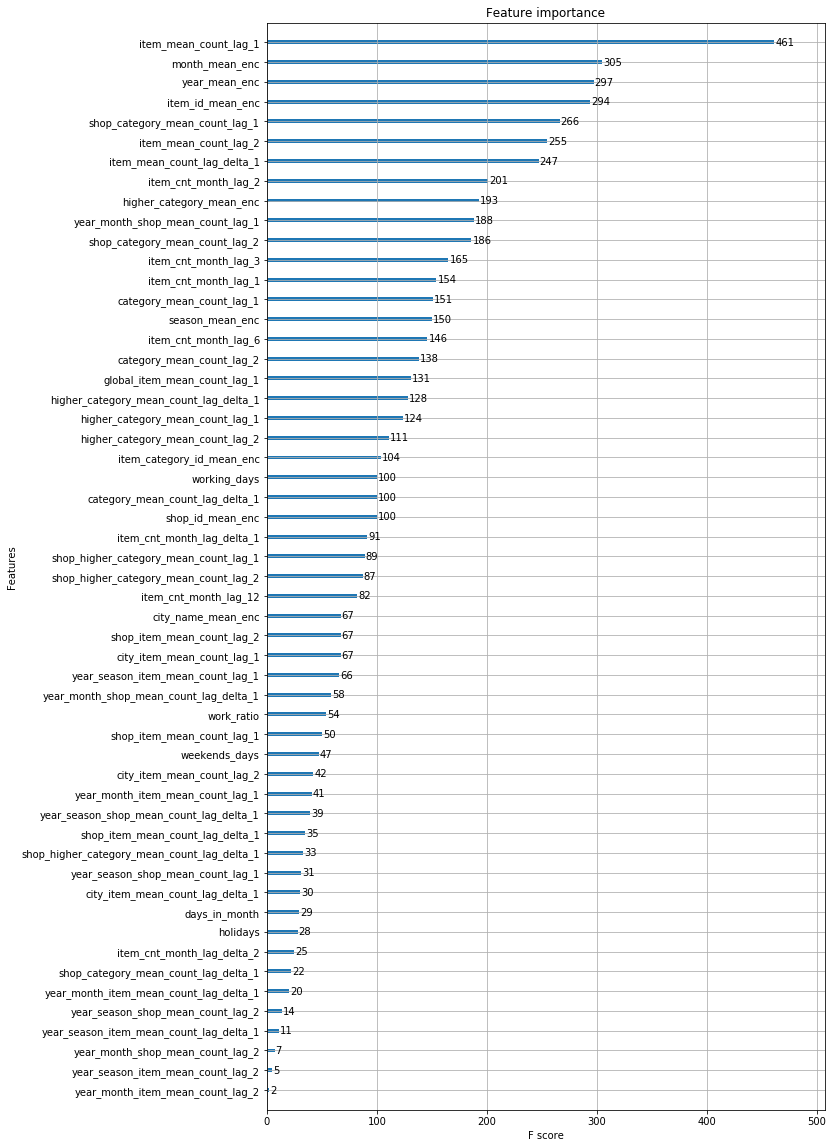

In [3]:
fig, ax = plt.subplots(figsize=(10, 20))
plot_importance(model, ax=ax)

plt.show()

In [4]:
def create_frame_importance():
    weight_dict = model.get_booster().get_score(importance_type='weight')
    feature_frame = pd.DataFrame({"columns": [col for col in weight_dict], 
                                  "weight": [weight_dict[col] for col in weight_dict]})
    feature_frame["Ranks"] = feature_frame["weight"].rank().astype(np.uint16)
    return feature_frame
    
feature_frame = create_frame_importance()

In [11]:
best_mse = 0.8705188035964966
best_index_rem = 24
tmp_cols_to_drop = feature_frame[feature_frame.Ranks <= best_index_rem]["columns"].values
cols_to_keep = [col for col in X_train.columns if not col in tmp_cols_to_drop]

In [33]:
X_train_preds = model.predict(X_train)
X_valid_preds = model.predict(X_valid)
X_test_preds = model.predict(X_test_eval)

In [34]:
with open('xg_boost_predict_best.pickle', 'wb') as f:
    Pickler(f).dump((X_train_preds, X_valid_preds, X_test_preds))

In [13]:
model = XGBRegressor(
        max_depth=8,
        n_estimators=1000,
        min_child_weight=300, 
        colsample_bytree=0.8, 
        subsample=0.8, 
        eta=0.3,    
        seed=42
    )
model.fit(
    X_train[cols_to_keep], 
    Y_train, 
    eval_metric = "rmse", 
    eval_set = [(X_train[cols_to_keep], Y_train), (X_valid[cols_to_keep], Y_valid)], 
    verbose = True, 
    early_stopping_rounds = 10
)

[0]	validation_0-rmse:1.16083	validation_1-rmse:1.12152
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.10435	validation_1-rmse:1.09028
[2]	validation_0-rmse:1.06655	validation_1-rmse:1.06245
[3]	validation_0-rmse:1.03331	validation_1-rmse:1.0361
[4]	validation_0-rmse:0.994605	validation_1-rmse:1.0184
[5]	validation_0-rmse:0.961029	validation_1-rmse:1.00329
[6]	validation_0-rmse:0.932635	validation_1-rmse:0.991219
[7]	validation_0-rmse:0.908674	validation_1-rmse:0.981093
[8]	validation_0-rmse:0.88827	validation_1-rmse:0.973115
[9]	validation_0-rmse:0.875799	validation_1-rmse:0.964536
[10]	validation_0-rmse:0.864554	validation_1-rmse:0.958641
[11]	validation_0-rmse:0.850438	validation_1-rmse:0.954405
[12]	validation_0-rmse:0.837799	validation_1-rmse:0.951453
[13]	validation_0-rmse:0.830366	validation_1-rmse:0.947168
[14]	validation_0-rmse:0.820918	valida

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.3, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=300, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8)

In [15]:
with open('xgboost_sub_cols.pickle', 'wb') as f:
    Pickler(f).dump(model)

In [ ]:
with open('xgboost_sub_cols.pickle', 'rb') as f:
    model = Unpickler(f).load()

In [23]:
X_train_preds = model.predict(X_train[cols_to_keep])
X_valid_preds = model.predict(X_valid[cols_to_keep])
X_test_preds = model.predict(X_test_eval[cols_to_keep])

In [17]:
with open('xg_boost_predict_best_sub_cols.pickle', 'wb') as f:
    Pickler(f).dump((X_train_preds, X_valid_preds, X_test_preds))

# Neural network used for preditction

In [37]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

def prepare_df_NN_scaler(input_frame):
    nn_scaler = StandardScaler()
    input_vals = nn_scaler.fit_transform(input_frame.values)
    return nn_scaler, input_vals

def prepare_df_NN(input_frame, scaler):
    return scaler.transform(input_frame.values)


def create_NN(input_shape, drop_rate = 0.2):
    cont_input = Input(shape=(input_shape,), name="continuous")

    x = Dense(20)(cont_input)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dense(20)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    out = Dense(1, activation='relu')(x)

    nn_model = Model(inputs=[cont_input], outputs=[out])
    nn_model.compile(loss='mse', optimizer='adam')
    return nn_model


def prepare_NN(X_train, X_valid, y_train, y_valid, drop_rate = 0.2):
    input_shape = X_train.shape[1]
    nn_scaler, X_train_nn_dict = prepare_df_NN_scaler(X_train)
    X_valid_nn_dict = prepare_df_NN(X_valid, nn_scaler)
    
    checkpoint_file = "./nn_model.h5"
    
    nn_model = create_NN(input_shape, drop_rate)
    balance_dict = {
        index: val for index, val in 
        enumerate(compute_class_weight("balanced" , np.unique(Y_train.values.flatten()), Y_train.values.flatten()))
       }
    callbacks = [
        TQDMNotebookCallback(),
        EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10),
        ModelCheckpoint(checkpoint_file, monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min')
    ]

    nn_model.fit(X_train_nn_dict, y_train.values, epochs=30, batch_size=1024, 
                 validation_data=(X_valid_nn_dict, y_valid.values), verbose=0, callbacks=callbacks)
    
    nn_model.load_weights(checkpoint_file)
    
    return nn_scaler, nn_model

In [66]:
nn_scaler, nn_model = prepare_NN(X_train, X_valid, Y_train, Y_valid)

In [70]:
with open('nn_scaler.pickle', 'wb') as f:
    Pickler(f).dump(nn_scaler)
    
nn_model.save_weights("./nn_model.h5")

In [25]:
with open('nn_scaler.pickle', 'rb') as f:
    nn_scaler = Unpickler(f).load()

nn_model = create_NN(X_train.shape[1])
nn_model.load_weights("./nn_model.h5")
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
continuous (InputLayer)      (None, 54)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1100      
_________________________________________________________________
batch_normalization_1 (Batch (None, 20)                80        
_________________________________________________________________
re_lu_1 (ReLU)               (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
batch_normalization_2 (Batch (None, 20)                80        
_________________________________________________________________
re_lu_2 (ReLU)               (None, 20)                0         
__________

In [27]:
X_train_preds = nn_model.predict(prepare_df_NN(X_train, nn_scaler))
X_valid_preds = nn_model.predict(prepare_df_NN(X_valid, nn_scaler))
X_test_preds = nn_model.predict(prepare_df_NN(X_test_eval, nn_scaler))

In [28]:
with open('nn_predict.pickle', 'wb') as f:
    Pickler(f).dump((X_train_preds, X_valid_preds, X_test_preds))

In [ ]:
nn_scaler, nn_model = prepare_NN(X_train[cols_to_keep], X_valid[cols_to_keep], Y_train, Y_valid, drop_rate=0.5)

775168/|/[loss: 0.583]  13%|| 775168/6115195 [00:25<01:04, 82907.75it/s]                                               

In [ ]:
with open('nn_scaler_sub_cols.pickle', 'wb') as f:
    Pickler(f).dump(nn_scaler)
    
nn_model.save_weights("./nn_scaler_sub_cols.h5")

In [ ]:
with open('nn_scaler_sub_cols.pickle', 'rb') as f:
    nn_scaler = Unpickler(f).load()

nn_model = create_NN(X_train[cols_to_keep].shape[1])
nn_model.load_weights("./nn_scaler_sub_cols.h5")
nn_model.summary()

In [32]:
X_train_preds = nn_model.predict(prepare_df_NN(X_train[cols_to_keep], nn_scaler))
X_valid_preds = nn_model.predict(prepare_df_NN(X_valid[cols_to_keep], nn_scaler))
X_test_preds = nn_model.predict(prepare_df_NN(X_test_eval[cols_to_keep], nn_scaler))

In [33]:
with open('nn_predict_sub_cols.pickle', 'wb') as f:
    Pickler(f).dump((X_train_preds, X_valid_preds, X_test_preds))

# KNN used for predictions

In [7]:
def check_for_K(X_train, X_valid, y_train, y_valid):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    print("Preparing dataframes")
    rmse_val = [] #to store rmse values for different k
    print("Running the KNN regressor")
    for K in range(15):
        K = K+1
        model = neighbors.KNeighborsRegressor(n_neighbors = K, n_jobs = 8)

        model.fit(X_train_scaled, y_train)  #fit the model
        pred=model.predict(X_valid_scaled) #make prediction on test set
        error = mean_squared_error(y_valid,pred) #calculate rmse
        rmse_val.append(error) #store rmse values
        print('MSE value for k= ' , K , 'is:', error)
    pd.DataFrame(rmse_val).plot()

def prepare_KNN_model(X_train, y_train, K, n_jobs = 8):
    model = neighbors.KNeighborsRegressor(n_neighbors = K, n_jobs = n_jobs)
    model.fit(X_train, y_train)
    return model

In [8]:
pca = PCA(n_components=14)
pca_X_train = pca.fit_transform(X_train)
pca_X_valid = pca.transform(X_valid)

Preparing dataframes
Running the KNN regressor
MSE value for k=  1 is: 1.3054137346119612
MSE value for k=  2 is: 1.1187156760660364
MSE value for k=  3 is: 1.0633575735182978
MSE value for k=  4 is: 1.0335786742354265
MSE value for k=  5 is: 1.0140117226206269
MSE value for k=  6 is: 1.0031734768710563
MSE value for k=  7 is: 0.9949647090920746
MSE value for k=  8 is: 0.989164999454176
MSE value for k=  9 is: 0.982961841250529
MSE value for k=  10 is: 0.9789798968812455
MSE value for k=  11 is: 0.9754407988781769
MSE value for k=  12 is: 0.9731862197627486
MSE value for k=  13 is: 0.9702680187268572
MSE value for k=  14 is: 0.9672845974457837
MSE value for k=  15 is: 0.9649885703515851


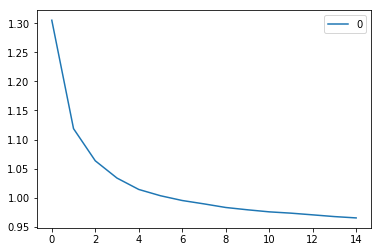

In [81]:
check_for_K(pca_X_train, pca_X_valid, Y_train, Y_valid)

In [10]:
knn_model = prepare_KNN_model(pca_X_train, Y_train, 12)

In [11]:
with open('knn_model.pickle', 'wb') as f:
    Pickler(f).dump(knn_model)
with open('knn_pca.pickle', 'wb') as f:
    Pickler(f).dump(pca)

In [ ]:
with open('knn_model.pickle', 'rb') as f:
    knn_model = Unpickler(f).load()
with open('knn_pca.pickle', 'rb') as f:
    pca = Unpickler(f).load()

In [12]:
X_train_preds = knn_model.predict(pca.transform(X_train))
X_valid_preds = knn_model.predict(pca.transform(X_valid))
X_test_preds = knn_model.predict(pca.transform(X_test_eval))

In [22]:
with open('knn_predict.pickle', 'wb') as f:
    Pickler(f).dump((X_train_preds, X_valid_preds, X_test_preds))

# Linear Regeresor model

In [12]:
linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)
print("Regression MSE:", mean_squared_error(linear_model.predict(X_valid), Y_valid))

Regression MSE: 0.9946096529492408


In [13]:
with open('linear_regression.pickle', 'wb') as f:
    Pickler(f).dump(linear_model)

In [14]:
with open('linear_regression.pickle', 'rb') as f:
    linear_model = Unpickler(f).load()

In [15]:
X_train_preds = linear_model.predict(X_train)
X_valid_preds = linear_model.predict(X_valid)
X_test_preds = linear_model.predict(X_test_eval)

In [16]:
with open('linear_predict.pickle', 'wb') as f:
    Pickler(f).dump((X_train_preds, X_valid_preds, X_test_preds))

In [17]:
linear_model = LinearRegression()
linear_model.fit(X_train[cols_to_keep], Y_train)
print("Regression MSE:", mean_squared_error(linear_model.predict(X_valid[cols_to_keep]), Y_valid))

Regression MSE: 1.002629300471746


In [18]:
with open('linear_regression_sub_cols.pickle', 'wb') as f:
    Pickler(f).dump(linear_model)

In [19]:
with open('linear_regression_sub_cols.pickle', 'rb') as f:
    linear_model = Unpickler(f).load()

In [20]:
X_train_preds = linear_model.predict(X_train[cols_to_keep])
X_valid_preds = linear_model.predict(X_valid[cols_to_keep])
X_test_preds = linear_model.predict(X_test_eval[cols_to_keep])

In [21]:
with open('linear_predict_sub_cols.pickle', 'wb') as f:
    Pickler(f).dump((X_train_preds, X_valid_preds, X_test_preds))

# Final top layer catboost predictor

In [6]:
with open('Y_values.pickle', 'rb') as f:
    X_test, Y_train, Y_valid = Unpickler(f).load()

In [2]:
pred_list = [
    ("xgboost", "./xg_boost_predict.pickle"),
    ("nn", "./nn_predict.pickle"),
    ("knn", "./knn_predict.pickle"),
    ("xgboost_sub_cols", "./xg_boost_predict_best_sub_cols.pickle"),
    ("nn_sub_cols", "./nn_predict_sub_cols.pickle"),
    ("linear_model", "./linear_predict.pickle"),
    ("linear_model_sub_cols", "./linear_predict_sub_cols.pickle"),
]

init = False

for type_name, pickle_path in tqdm(pred_list):
    with open(pickle_path, 'rb') as f:
        X_train_preds, X_valid_preds, X_test_preds = Unpickler(f).load()
    X_train_preds = X_train_preds.reshape(-1, 1)
    X_valid_preds = X_valid_preds.reshape(-1, 1)
    X_test_preds = X_test_preds.reshape(-1, 1)
    if(not init):
        init = True
        final_train = X_train_preds
        final_valid = X_valid_preds
        final_test = X_test_preds
    else:
        final_train = np.hstack((final_train, X_train_preds))
        final_valid = np.hstack((final_valid, X_valid_preds))
        final_test = np.hstack((final_test, X_test_preds))

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  2.79it/s]


# Add difs of each base predictor

In [3]:
def diff_lists(in_list, first, second):
    return (in_list[:, first] - in_list[:, second]).reshape(-1, 1)

def ratio_lists(in_list, first, second):
    return ((in_list[:, first] + 1e-6 ) / (in_list[:, second] + 1e-6)).reshape(-1, 1)

for x in tqdm(range(len(pred_list))):
    for y in range(len(pred_list)):
        if x < y:
            final_train = np.hstack((final_train, diff_lists(final_train,x,y)))
            final_valid = np.hstack((final_valid, diff_lists(final_valid,x,y)))
            final_test = np.hstack((final_test, diff_lists(final_test,x,y)))
            
            final_train = np.hstack((final_train, ratio_lists(final_train,x,y)))
            final_valid = np.hstack((final_valid, ratio_lists(final_valid,x,y)))
            final_test = np.hstack((final_test, ratio_lists(final_test,x,y)))

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:19<00:00, 11.34s/it]


In [7]:
top_model = LinearRegression()

top_model.fit(
    final_train, 
    Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [7]:
with open('final_top_model.pickle', 'wb') as f:
    Pickler(f).dump(top_model)

In [8]:
with open('final_top_model.pickle', 'rb') as f:
    top_model = Unpickler(f).load()

# Prepare final submission

In [8]:
pred_vals = top_model.predict(final_test).clip(0, 20).flatten()

In [9]:
pred_frame = pd.DataFrame({"ID": list(range(len(pred_vals))), "item_cnt_month": pred_vals})

In [10]:
pred_frame.to_csv("./submission.csv", index=False)